# Project 3: Panoramic Mosaicing

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Part A: <span style="color:red;">10 minutes</span>
* 2. Part B: <span style="color:red;">1 hour</span>
* 3. Part C: <span style="color:red;">5 hours</span>
* 4. Part D: <span style="color:red;">5 hours</span>
* 5. Write-up: <span style="color:red;">15 minutes</span>

### Programming Exercise

For this assignment, you will be writing a program that creates a panoramic mosaic from 2 or more images.  In general this technique should be applicable to any number of photographs.  The approach described below will work well for collective fields of up to 90 or even 120&deg;, but won't produce ideal results for large fields of view approaching or surpassing 180&deg;.  For large fields of view cylindrical or spherical projection is required.

When we construct a panorama, we assume that all of the photographs were taken from the exact same location and that the images are related by pure rotation (no translation of the camera).  The easiest way to create the panorama is to project all of the photos onto a plane.  One photo must be selected (either manually or by your program) to be the base photo.  The other photos are aligned to this base photo by identifying a homography (a planar warp specified by 4 pairs of source/destination points) relating each pair.  Each of the other images is appropriately warped and composited onto the plane (the base image doesn’t need to be warped).

In describing what you need to do, there will be a running example using the three photos below:


<div style="width:100%;text-align:center;"><img src="Images/example1.png" width=100%></div>
        

### Part A: Find Interest Points/Descriptors in each Input Image
We will be using OpenCV for this project, which you should already have installed.  However, you may need to install the contrib version--which comes seperate due to the SIFT algorithm being patented--by running the command:`pip install opencv-contrib-python`.  A good tutorial on how to use SIFT features in OpenCV is found [here](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html).  The first step to registering or aligning two images is to identify locations in each image that are distinctive or stand out.  The `sift.detectAndCompute()` routine produces both these interest points and their corresponding SIFT descriptors.  The first step of producing a panorama is to load all of the relevant images and find the interest points and their descriptors.

See the red circles on each image below indicating the sift keypoints that were found (note that we downsampled the images to 600 x 600 pixels before extracting SIFT).  We scaled the circles according to the scale at which each keypoint was detected at.

<div style="width:100%;text-align:center;"><img src="Images/example2.png" width=100%></div>

### Part B: Matching Features

Next, given the features present in each image, you need to match the features so as to determine corresponding points between adjacent/overlapping images.  [This page](https://docs.opencv.org/trunk/dc/dc3/tutorial_py_matcher.html) provides details to do feature matching using `cv2.BFMatcher()`, analogous to the approach proposed by David Lowe in his original implementation.  Be aware that the resulting match is one directional.  You want to find putative pairs--pairs of points which are each other’s best match (e.g. there might be 3 points in image I1 for which a point q in image I2 are the best match, only one of these could be the best matching point p in I1 for that point q in I2).  In this part you need to compute the set of putative matches between each pair of images.

Look at the pairs of images and the lines showing the estimated matches (putative matches are green lines, one way matches are cyan or blue).

<div style="width:100%;text-align:center;"><img src="Images/example3.png" width=100%></div>

### Part C: Estimating Pairwise Homographies using RANSAC

Use the RANSAC algorithm ([Szeliski](http://szeliski.org/Book/), Ch 6.1.4), estimate the homography between each pair of images.  You will need to decide whether you’re going to manually specify the base image or determine in programmatically.  Along with identifying the base image, you need to figure out the order in which you will composite the other images to the base.

You will need 4 pairs of points to estimate a homography.  Begin by randomly sampling sets of 4 pairs and estimating the corresponding homography for each set.  Instead of the two warping equations that we used earlier in the semester, it is recommended that you use a 3x3 homography (8 unknowns).  You are trying to estimate the homography

$$
\begin{bmatrix}a & b & c\\d & e & f\\g & h & 1\end{bmatrix}
$$

such that a point $(x_s,y_s)$ in the source image is tranformed to a point $(x_t,y_t)$ in the target image as follows

$$
\begin{bmatrix}x_t\\y_t\\1\end{bmatrix} = \begin{bmatrix}a & b & c\\d & e & f\\g & h & 1\end{bmatrix}\begin{bmatrix}x_s\\y_s\\1\end{bmatrix}
$$

Each pair of points will produce three linear equations in (a subset of) the 8 unknowns.  For example, $x_t = x_sa + y_sb + c$.  Four pairs of points (assuming no degeneracies) are sufficient to estimate the homography.  A more robust solution relying on more than four pairs can be obtained using least squares on the overconstrained linear system (solving $Ax = b$, where $x$ is a column vector with the 8 unknowns and you populate rows of $A$ and an entry of $b$ with the linear equations just described).  Note that this solution will **not** always be better.

Because of the homogeneous coordinates, the three equations can be reduced to two equations as follows:

$$
x_t = \frac{ax_s+by_s+c}{gx_s+hy_s+1}, \hspace{5mm}
y_t = \frac{dx_s+ey_s+f}{gx_s+hy_s+1}
$$

For more details, see the [image alignment and stitching slides](https://faculty.cs.byu.edu/~farrell/courses/CS450/slides/alignment_stitching.pdf#page=18).

Below you will find a visualization of the RANSAC estimated homographies.  Images 1, 2, and 3 have dots that are red, green and blue respectively (sorry the dots are a little small), representing the putative pairs.  You can see where the homographies line up very well and in a few places (the middle vertically) they line up slightly less well.

<div style="width:100%;text-align:center;"><img src="Images/example4.png" width=100%></div>

### Part D: Creating the Mosaic

Begin with the base image and warp the remaining images (using the estimated homographies) to composite them onto the base image.

For the ongoing campus example, here are the resulting warped images composited.

<div style="width:100%;text-align:center;"><img src="Images/example5.png" width=75%></div>

And, then with a very simple (but not ideal) compositing operation.

<div style="width:100%;text-align:center;"><img src="Images/example6.png" width=75%></div>

In [381]:
 %pylab inline

Populating the interactive namespace from numpy and matplotlib


In [382]:
import numpy as np
import random
import copy
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm  # notebook compatible

plt.rcParams['figure.figsize'] = [15,8]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'

def just_title(title):
    a = plt.gca()
    a.set_title(title, fontdict={'fontsize': rcParams['axes.titlesize'],
                                 'fontweight' : rcParams['axes.titleweight'],
                                 'verticalalignment': 'baseline',
                                 'horizontalalignment': 'center'})
    a.set_xticks([])
    a.set_yticks([])
    
    
def color2gray(image):
    result = image[:, :, 0] * 0.299 + image[:, :, 1] * 0.587 + image[:, :, 2] * 0.114
    return result

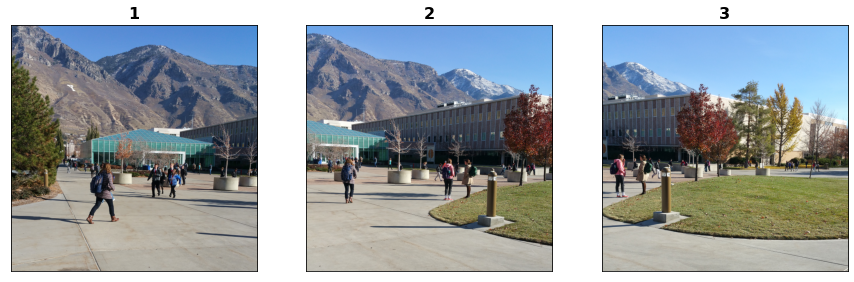

In [383]:
img1 = cv2.imread('images/campus1_sq600.png')
img2 = cv2.imread('images/campus2_sq600.png')
img3 = cv2.imread('images/campus3_sq600.png')

def rgb(img):
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return RGB_img


plt.subplot(131)
plt.imshow(rgb(img1))
just_title("1")

plt.subplot(132)
plt.imshow(rgb(img2))
just_title("2")

plt.subplot(133)
plt.imshow(rgb(img3))
just_title("3")

### Part A: Find Interest Points/Descriptors

In [384]:
# Show an example output here
def load_feats(data_path: int) -> tuple:
    data = np.load(data_path)
    feats, descrs = data["feats"], data["descrs"]
    return feats, descrs

def draw_circles(og_img: np.array, feats: np.array) -> np.array:
    img = rgb(copy.deepcopy(og_img))
    for row in range(feats.shape[0]):
        x, y, _, scale = feats[row].tolist()
        cv2.circle(img, (int(x), int(y)), int(scale), color=(255, 0, 0), thickness=cv2.FILLED)
    return img

feats1, descrs1 = load_feats("feats/campus{}_sift.npz".format(1))
feats2, descrs2 = load_feats("feats/campus{}_sift.npz".format(2))
feats3, descrs3 = load_feats("feats/campus{}_sift.npz".format(3))

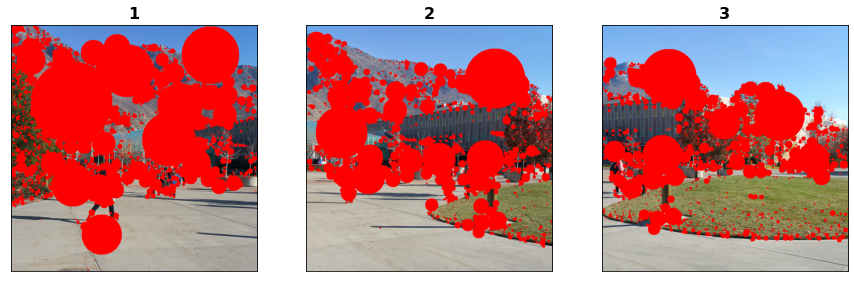

In [385]:
points1 = draw_circles(img1, feats1)
points2 = draw_circles(img2, feats2)
points3 = draw_circles(img3, feats3)

plt.subplot(131)
plt.imshow(points1)
just_title("1")

plt.subplot(132)
plt.imshow(points2)
just_title("2")

plt.subplot(133)
plt.imshow(points3)
just_title("3")

### Part B: Matching Features

In [386]:
from scipy.spatial.distance import cdist # used to make my implementation faster

def match_features_cv2(img1, img2, descrs1, descrs2, feats1, feats2, ratio=0.75):
    kp1 = [cv2.KeyPoint(*feats1[index].tolist()) for index in range(feats1.shape[0])]
    kp2 = [cv2.KeyPoint(*feats2[index].tolist()) for index in range(feats2.shape[0])]
    
    bf = cv2.BFMatcher()
    # matches = bf.match(descrs1,descrs2)
    matches = bf.knnMatch(descrs1,descrs2,k=2)

    # Sort them in the order of their distance.
    # matches = sorted(matches, key = lambda x:x.distance)
    

    # Apply ratio test
    good = []
    good_points = []
    for m,n in matches:
        if m.distance < ratio*n.distance:
            good.append([m])
            p1 = kp1[m.queryIdx].pt
            p2 = kp2[m.trainIdx].pt
            good_points.append((p1, p2))
    # cv.drawMatchesKnn expects list of lists as matches.
    # Draw first N matches.
    combined = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    #combined = cv2.drawMatches(img1, kp1, img2, kp2, matches[:n_matches], None, flags=2)
    return combined, good_points


def match_features_done_by_me(img1, img2, descrs1, descrs2, feats1, feats2, use_scipy_dist=True, dist=None, ratio=0.75, 
                              dist_type="euclidean"):
    kp1 = [cv2.KeyPoint(*feats1[index].tolist()) for index in range(feats1.shape[0])]
    kp2 = [cv2.KeyPoint(*feats2[index].tolist()) for index in range(feats2.shape[0])]
    
    if dist is None:
        
        if use_scipy_dist:
            # much faster implementation but same results
            dist = cdist(descrs1, descrs2, dist_type)
        else:
            # The following shows I can implement it, but it's very slow.
            dist = np.zeros((len(descrs1), len(descrs2)))
            for idx1, ind_desc1 in enumerate(descrs1):
                for idx2, ind_desc2 in enumerate(descrs2):
                    l2_dist = np.linalg.norm(ind_desc1-ind_desc2)
                    dist[idx1, idx2] = l2_dist
     
    # go through each match and convert it to a DMatch type, to use cv2's plotting method
    matches = []
    for idx in range(len(descrs1)):
        ind_min = dist[idx, :].argmin()
        if dist[:, ind_min].argmin() == idx:
            indexes_of_mins = np.argpartition(dist[idx, :], 2)[:2].tolist()
            indexes_of_mins = np.array(indexes_of_mins)
            scores_of_mins = dist[idx, :][indexes_of_mins]
            m = cv2.DMatch(idx, ind_min, scores_of_mins[0])
            n = cv2.DMatch(idx, indexes_of_mins[-1], scores_of_mins[1])
            matches.append((m, n))
            
    # Apply ratio test
    good = []
    good_points = []
    for m,n in matches:
        if m.distance < ratio*n.distance:
            good.append([m])
            # append points for opencv plotting
            p1 = kp1[m.queryIdx].pt
            p2 = kp2[m.trainIdx].pt
            good_points.append((p1, p2))

    combined = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return combined, good_points

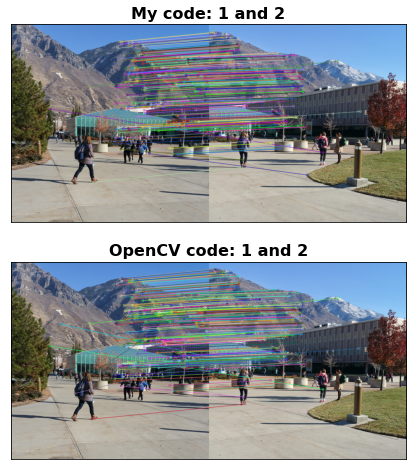

In [387]:
combined_me, good_points = match_features_done_by_me(img1, img2, descrs1, descrs2, feats1, feats2)
plt.subplot(211)
plt.imshow(rgb(combined_me))
just_title("My code: 1 and 2")
plt.subplot(212)
combined1 = rgb(match_features_cv2(img1, img2, descrs1, descrs2, feats1, feats2)[0])
plt.imshow(combined1)
just_title("OpenCV code: 1 and 2")

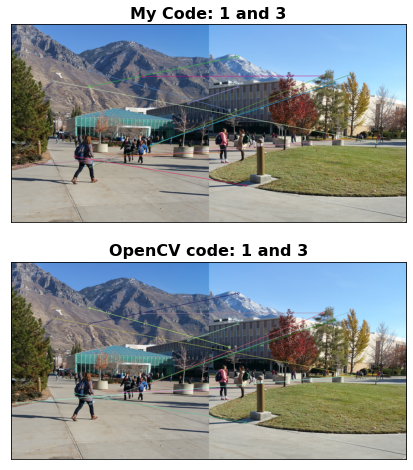

In [388]:
combined2 = rgb(match_features_done_by_me(img1, img3, descrs1, descrs3, feats1, feats3)[0])
plt.subplot(211)
plt.imshow(combined2)
just_title("My Code: 1 and 3")

combined2 = rgb(match_features_cv2(img1, img3, descrs1, descrs3, feats1, feats3)[0])
plt.subplot(212)
plt.imshow(combined2)
just_title("OpenCV code: 1 and 3")

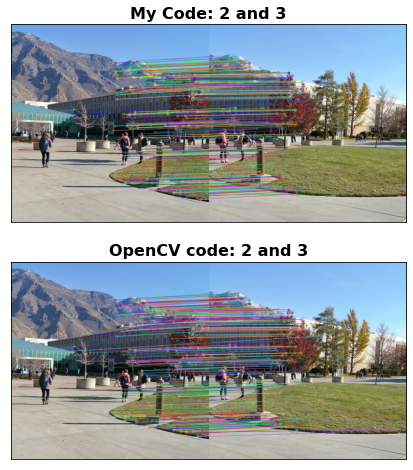

In [389]:
combined3 = rgb(match_features_done_by_me(img2, img3, descrs2, descrs3, feats2, feats3)[0])
plt.subplot(211)
plt.imshow(combined3)
just_title("My Code: 2 and 3")

combined3 = rgb(match_features_cv2(img2, img3, descrs2, descrs3, feats2, feats3)[0])
plt.subplot(212)
plt.imshow(combined3)
just_title("OpenCV code: 2 and 3")

### Part C: Estimating Pairwise Homographies using RANSAC

In [390]:
import random
random.seed(24)
import itertools
np.set_printoptions(suppress=True)

def check_collinearity(four_points: list) -> bool:
    for group in itertools.combinations(four_points, 3):
        img1_group = [item[0] for item in group]
        img2_group = [item[1] for item in group]
        if collinear(*img1_group) or collinear(*img2_group):
            return True
    else:
        return False

def collinear(p1, p2, p3): 
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    if abs((y3 - y2)*(x2 - x1) - (y2 - y1)*(x3 - x2)) < 1000: 
        return True
    else: 
        return False

def build_matrix_for_homography(points) -> tuple:
    matrix = np.zeros((len(points) * 2, 8))
    answer = np.zeros(len(points) * 2)
    for index, ((p1_x, p1_y), (p2_x, p2_y)) in enumerate(points):
        # first row
        matrix[index * 2, :] = np.array([p1_x, p1_y, 1, 0, 0, 0, -1*p2_x*p1_x, -1*p2_x*p1_y])
        answer[index * 2] = p2_x
        # next row
        matrix[index * 2 + 1, :] = np.array([0, 0, 0, p1_x, p1_y, 1, -1*p2_y*p1_x, -1*p2_y*p1_y])
        answer[index * 2 + 1] = p2_y
    return matrix, answer
        
flatten = lambda l: [item for sublist in l for item in sublist]

In [391]:
def get_homeography(matches: list, img1, img2, n_iters=200, seed=42, use_cv2=False):
    """ Puts image1 on image 2 """
    if use_cv2:
        src_pts = np.array(flatten([item[0] for item in matches])).reshape((-1, 2))
        dst_pts = np.array(flatten([item[1] for item in matches])).reshape((-1, 2))
        cv_homography = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 0.05 * 255)[0]
        return cv_homography
    
    random.seed(seed)
    img1_group = np.array(flatten([item[0] for item in matches])).reshape((-1, 2))
    img2_group = np.array(flatten([item[1] for item in matches])).reshape((-1, 2))

    best_count = -1
    best_homeography = None
    best_points = None

    for iteration in range(n_iters):
        # randomly pick from punative matches
        colinear = True
        while colinear:
            four_points = random.sample(matches, k=4)
            colinear = check_collinearity(four_points)
        a, b, = build_matrix_for_homography(four_points)

        # get the homeography and convert it
        homeography = np.linalg.solve(a, b).tolist()
        homeography.append(1)
        homeography = np.array(homeography).reshape((3, 3))

        # get the converted images and points in np form
        converted_img = cv2.warpPerspective(img1, homeography, (img1.shape[0], img1.shape[1]))
        img1_group = img1_group.round().astype(int)
        img2_group = img2_group.round().astype(int)

        # compute the difference between the real image and homeography translation
        computed_vals = converted_img[tuple(img1_group.T)] # subsets all at once

        real_vals = img2[tuple(img2_group.T)]
        diffs = np.abs(real_vals - computed_vals)
        
        count_same = (diffs.sum(axis=1) < 70).sum()
        matching_points = (diffs.sum(axis=1) < 70)

        # save it, if it's the best
        if count_same > best_count:
            best_homeography = homeography
            best_count = count_same
            best_points = matching_points
    
    indexes_to_use = numpy.where(best_points)[0].tolist()
    if len(indexes_to_use):
        best_points_all = [matches[i] for i in indexes_to_use]
        # use all good points to create the homoegraphy
        finalA, finalB = build_matrix_for_homography(best_points_all)
        # use least squares to appx
        result = np.linalg.lstsq(finalA, finalB, rcond=None)[0].tolist()
        result.append(1)
        final_homeography = np.array(result).reshape((3, 3))
    else:
        final_homeography = best_homeography
    return final_homeography

In [392]:
_, matches = match_features_done_by_me(img1, img2, descrs1, descrs2, feats1, feats2)
src_pts = np.array(flatten([item[0] for item in matches])).reshape((-1, 2))
dst_pts = np.array(flatten([item[1] for item in matches])).reshape((-1, 2))
my_homeography = get_homeography(matches, img1, img2)
cv_homography = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 0.05 * 255)[0] # use the pixel threshold to match mine
print(f"My homography: \n{my_homeography}, \n\nOpenCV Homography: \n{cv_homography}")
print("\n\nNOTE: These are close, but not exact, due to the randomness factor")

My homography: 
[[   1.11019022    0.0735316  -355.07861253]
 [   0.09138935    1.09181117  -60.44241418]
 [   0.00017574    0.00002051    1.        ]], 

OpenCV Homography: 
[[   1.2511483     0.06504637 -402.30335633]
 [   0.13663601    1.18845144  -81.52886206]
 [   0.00040621    0.00000157    1.        ]]


NOTE: These are close, but not exact, due to the randomness factor


### Part D: Creating the Mosaic

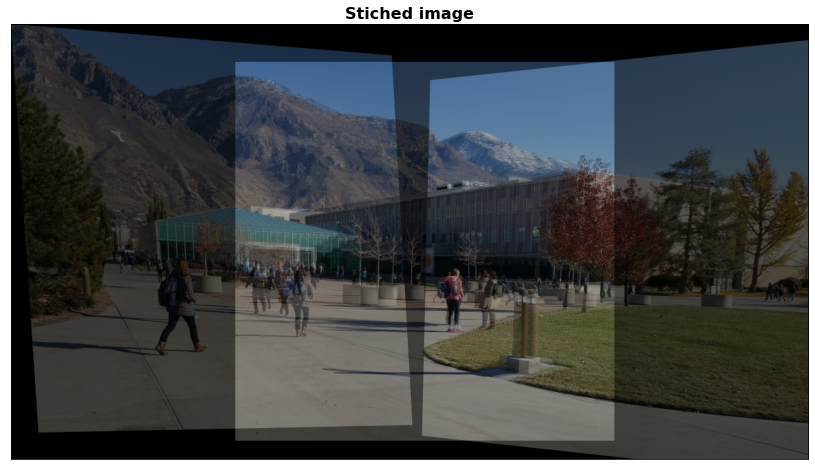

In [393]:
def create_mosiac(img1, img2, img3, descrs1, descrs2, descrs3, feats1, feats2, feats3, seed=42, use_cv2=False):
    # get the left image homography
    combined1, matches1 = match_features_done_by_me(img1, img2, descrs1, descrs2, feats1, feats2)
    l_H = get_homeography(matches1, img1, img2, seed=seed, use_cv2=use_cv2)

    # get the right image homography
    combined1, matches3 = match_features_done_by_me(img3, img2, descrs3, descrs2, feats3, feats2)
    r_H = get_homeography(matches3, img3, img2, seed=seed+1, use_cv2=use_cv2)
    
#     print(l_H, "\n", r_H, "\n")

    shift_x_l = round(abs(l_H[0, 2]))
    shift_y_l = round(abs(l_H[1, 2]))
    shift_x_r = round(abs(r_H[0, 2]))
    shift_y_r = round(abs(r_H[1, 2]))

    mid_shift = np.eye(3)
    mid_shift[0, 2] = shift_x_l
    mid_shift[1, 2] = shift_y_l
    
#     print(mid_shift, "\n", r_H, "\n")

    l_H[0, 2] = 0
    l_H[1, 2] = 0

    r_H[0, 2] += shift_x_l
    r_H[1, 2] += shift_y_l

    result = cv2.warpPerspective(rgb(img1), l_H, (shift_x_l+shift_x_r+600, 600+shift_y_l+shift_y_r))
    result_mid = cv2.warpPerspective(rgb(img2), mid_shift, (shift_x_l+shift_x_r+600, 600+shift_y_l+shift_y_r))
    result_right = cv2.warpPerspective(rgb(img3), r_H, (shift_x_l+shift_x_r+600, 600+shift_y_l+shift_y_r))
    result = np.mean([result, result_mid, result_right], axis=0).astype(int)
    return result

result = create_mosiac(img1, img2, img3, descrs1, descrs2, descrs3, feats1, feats2, feats3, use_cv2=False)
plt.imshow(result)
just_title("Stiched image")

## Temple Results

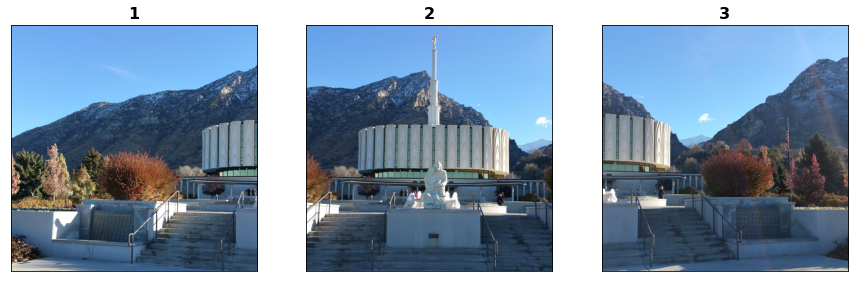

In [394]:
img1_temple = cv2.imread('images/temple_horiz1_sq600.png')
img2_temple = cv2.imread('images/temple_horiz2_sq600.png')
img3_temple = cv2.imread('images/temple_horiz3_sq600.png')

plt.subplot(131)
plt.imshow(rgb(img1_temple))
just_title("1")

plt.subplot(132)
plt.imshow(rgb(img2_temple))
just_title("2")

plt.subplot(133)
plt.imshow(rgb(img3_temple))
just_title("3")

feats1_temple, descrs1_temple = load_feats("feats/temple_horiz{}_sift.npz".format(1))
feats2_temple, descrs2_temple = load_feats("feats/temple_horiz{}_sift.npz".format(2))
feats3_temple, descrs3_temple = load_feats("feats/temple_horiz{}_sift.npz".format(3))

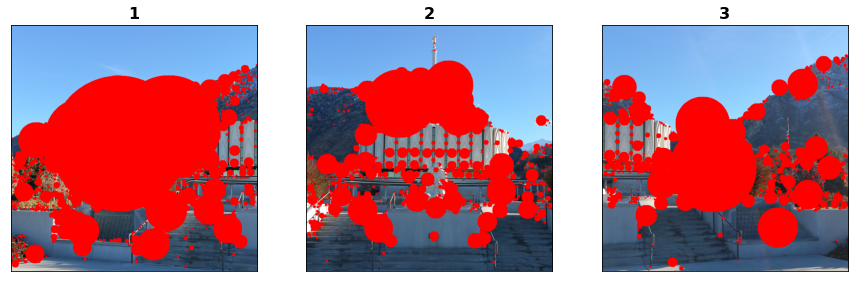

In [395]:
points1 = draw_circles(img1_temple, feats1_temple)
points2 = draw_circles(img2_temple, feats2_temple)
points3 = draw_circles(img3_temple, feats3_temple)

plt.subplot(131)
plt.imshow(points1)
just_title("1")

plt.subplot(132)
plt.imshow(points2)
just_title("2")

plt.subplot(133)
plt.imshow(points3)
just_title("3")

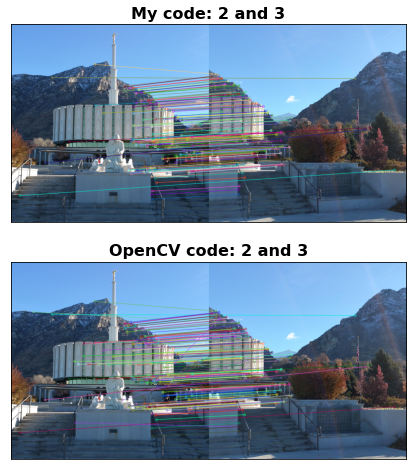

In [396]:
combined_me, good_points = match_features_done_by_me(img2_temple, img3_temple, descrs2_temple, 
                                                         descrs3_temple, feats2_temple, feats3_temple)
plt.subplot(211)
plt.imshow(rgb(combined_me))
just_title("My code: 2 and 3")
plt.subplot(212)
combined1 = rgb(match_features_cv2(img2_temple, img3_temple, descrs2_temple,
                                    descrs3_temple, feats2_temple, feats3_temple)[0])
plt.imshow(combined1)
just_title("OpenCV code: 2 and 3")
# I didn't plot others but they're similar....

In [397]:
_, matches = match_features_done_by_me(img1_temple, img2_temple, descrs1_temple, descrs2_temple, feats1_temple, feats2_temple)
src_pts = np.array(flatten([item[0] for item in matches])).reshape((-1, 2))
dst_pts = np.array(flatten([item[1] for item in matches])).reshape((-1, 2))
my_homeography = get_homeography(matches, img1_temple, img2_temple)
cv_homography = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 0.05 * 255)[0] # use the pixel threshold to match mine
print(f"My homography: \n{my_homeography}, \n\nOpenCV Homography: \n{cv_homography}")
print("\n\nNOTE: These are close, but not exact, due to the randomness factor")

My homography: 
[[   1.00654968   -0.0261475  -325.40772417]
 [   0.00462027    1.11376521  -22.13054484]
 [  -0.000024      0.0001775     1.        ]], 

OpenCV Homography: 
[[   1.43256573   -0.04690367 -484.92839035]
 [   0.29028412    1.32052379 -132.04257249]
 [   0.00072116   -0.00003445    1.        ]]


NOTE: These are close, but not exact, due to the randomness factor


In [398]:
_, matches = match_features_done_by_me(img3_temple, img2_temple, descrs3_temple, descrs2_temple, feats3_temple, feats2_temple)
src_pts = np.array(flatten([item[0] for item in matches])).reshape((-1, 2))
dst_pts = np.array(flatten([item[1] for item in matches])).reshape((-1, 2))
my_homeography = get_homeography(matches, img1_temple, img2_temple)
cv_homography = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 0.05 * 255)[0] # use the pixel threshold to match mine
print(f"My homography: \n{my_homeography}, \n\nOpenCV Homography: \n{cv_homography}")
print("\n\nNOTE: These are close, but not exact, due to the randomness factor")

My homography: 
[[  0.67124156   0.04020331 331.13993866]
 [ -0.21533194   0.94655968  42.40240991]
 [ -0.00052159   0.00002709   1.        ]], 

OpenCV Homography: 
[[  0.67677758   0.01162994 331.68708444]
 [ -0.20129013   0.90943762  46.39745349]
 [ -0.00049905  -0.00003381   1.        ]]


NOTE: These are close, but not exact, due to the randomness factor


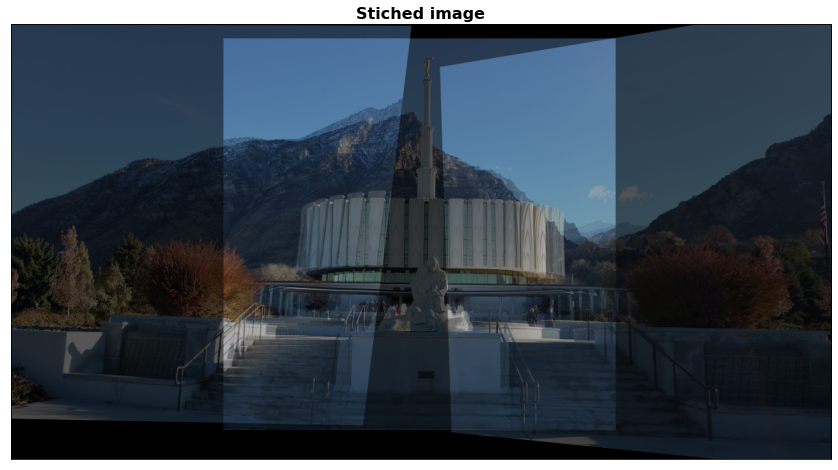

In [399]:
result_temple = create_mosiac(img1_temple, img2_temple, img3_temple, descrs1_temple, descrs2_temple,
                           descrs3_temple, feats1_temple, feats2_temple, feats3_temple, use_cv2=False)
plt.imshow(result_temple)
just_title("Stiched image")
# for some reason it gets the stairs really well but mis-aligns part of the mtn

### Final Results and Improvements

In [400]:
## I implemented the BFMacher function myself (with all my code above using it), so that was my additional improvement

### Grading

To get 100% you need to (i) implement RANSAC and additionally (ii) either implement the feature matching yourself (instead of using built-in matching functions such as `cv2.BFMatcher()`), or incorporate one of the following improvements:
* A nice clean compositing/blending approach so that edges/artifacts are not noticeable.
* Automatic selection of which image should be the base
* Handling more than 3 photos
* Another enhancement approved by Dr. Farrell

Points for this assigment will be assigned as follows (100 points total):
* [10 pts] Extracting features from both images (interest points and descriptors).
* [20 pts] Four-point algorithm to estimate homographies.
* [30 pts] RANSAC implemented (partial points given for poor alignments).
* [20 pts] Images warped appropriately (aligning on top of each other).
* [10 pts] Clean final image (extents of merged image should fit the enscribed rectangle).
* [10 pts] Implementing matching or other improvement (see above). Bonus points may be given for additional enhancements.

## Write-up:
Provide an explanation for the following items:
* In what scenarios was it difficult to get good alignments between images?
* If you have any suggestions for how to improve this project in the future, list them here.

## Write Up
1. It was difficult to get good alignments between images when there were a lot of false positives on the matches.
This was pretty clear on the Provo Temple case, because the temple pattern looks the same on all sides, so there
was a decent amount of false positives to wrong parts of the temple.
2. I don't really have any suggestions for improving this lab, I though this was a fun one.  It was difficult,
I think the hardest we've done yet, but still good to know and learn.